## Aggregating VIIRS Night Time Lights (NTL) Data for Quintana Roo

In [1]:
# Import GEE & initialize
import os
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Initialize GEE
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

##  Source Data

In [2]:
# Quintana Roo state boundary
states = ['Quintana Roo', 'Yucatan','Oaxaca','Sonora','Cayo','Santander', 'Ceara', 'Alabama','Karnataka','Kolda']
state = "Quintana Roo"
QRAdmin = ee.FeatureCollection("FAO/GAUL/2015/level1") \
            .filterMetadata("ADM1_NAME", "equals", state)  

#VIIRS Nightime Lights 
# VCMSLCFG -- stray light corrected, 
# VCMCFG --- "filtered to exclude data impacted by stray light, lightning, lunar illumination, and cloud-cover"
NTL = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")\
              .filterBounds(QRAdmin.geometry()) \
              .sort('system:time_start')
print(NTL.size().getInfo())
print(NTL.first().bandNames().getInfo())
print(NTL.geometry().getInfo())

ntl_radiance = NTL.select('avg_rad')

99
['avg_rad', 'cf_cvg']
{'type': 'Polygon', 'coordinates': [[[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]]}


In [3]:
# Clipped version of NTL collection
NTLclipped = NTL.map(lambda img: img.clipToCollection(QRAdmin))

print(NTLclipped.size().getInfo())
# print(NTLclipped.first().bandNames().getInfo())

99


In [4]:
# Quick Viz to compare 
lat=20
lon=-87
map1 = geemap.Map(center=[lat, lon],zoom=7)
# map1.add_basemap('SATELLITE')
map1.addLayer(NTLclipped, {}, "NTL Clipped")
map1.addLayer(NTL, {}, "NTL", False)
map1.addLayerControl()
map1

Map(center=[20, -87], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

## Fix discontinuity due to calibration change in January 2017

In [5]:
# Split collection into two date ranges -- pre Jan 2017 and post Jan 2017
NTLpre2017 = NTL.filterDate('2012-04-01', '2016-12-31')
NTLpost2017 = NTL.filterDate('2017-01-01', '2020-12-31')
print(NTLpre2017.size().getInfo())
print(NTLpost2017.size().getInfo())

def adjustRadiance(image):
    # rad_constant = 0.15  #  Coesfeld et al., 2020 https://doi.org/10.3390/s20113287
    rad_constant = 0.125 # Elvidge et al., 2020, https://doi.org/10.3390/rs12193194
    return image.add(rad_constant).copyProperties(image, ['system:time_start','system:time_end'])

# Adjust the pre-2017 radiance
NTLpre2017 = NTLpre2017.map(adjustRadiance)
# Combine adjusted pre-2017 back with post 2017
NTLadjusted = NTLpre2017.merge(NTLpost2017)
print(NTLadjusted.size().getInfo())

# Add the date as a property
NTLadjusted = NTLadjusted.map(lambda img: img.set('ntldate',img.date().format('YYYYMMdd')))

# Pull out just the radiance band
ntl_radiance = NTLadjusted.select('avg_rad')

print(NTLadjusted.first().propertyNames().getInfo())
print(NTLadjusted.first().getInfo())

57
42
99
['system:time_start', 'ntldate', 'system:time_end', 'system:index', 'system:bands', 'system:band_names']
{'type': 'Image', 'bands': [{'id': 'avg_rad', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [0.0041666667, 0, -180.00208525335, 0, -0.0041666667, 75.00208393335001]}, {'id': 'cf_cvg', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0.125, 'max': 65535.125}, 'crs': 'EPSG:4326', 'crs_transform': [0.0041666667, 0, -180.00208525335, 0, -0.0041666667, 75.00208393335001]}], 'properties': {'system:time_start': 1333238400000, 'ntldate': '20120401', 'system:time_end': 1335830400000, 'system:index': '1_20120401'}}


## Aggregate / Summarize Data

### Sum of Lights (averge radiance) Across QR

In [6]:
# Reduce Regions to Sum of pixels and pixel count
def ntlSum(image):
    # Reducers -- sum and count of pixels
    reducers = ee.Reducer.sum().combine(**{
    'reducer2': ee.Reducer.count(),
    'sharedInputs': True
    })
    # Reduce Region (single region, QR) 
    ntlSumQR = image.reduceRegions(**{
    'collection': QRAdmin,
    'reducer': reducers,
    'scale': 450,
    })
    ntlSumQR = ntlSumQR.map(lambda f: f.set('ntldate', image.get('ntldate')))
    return ntlSumQR # Returned object is a FeatureCollection


### Monthly

In [7]:
# Create a Feature Collection with one feature per date 
#  with the SUM of NTL avg radiances
sumNTLQR = ntl_radiance.map(ntlSum).flatten()
print(sumNTLQR.size().getInfo()) 
print(sumNTLQR.first().propertyNames().getInfo()) 

99
['system:index', 'ntldate', 'sum', 'count', 'Shape_Leng', 'ADM1_CODE', 'STATUS', 'ADM0_NAME', 'ADM0_CODE', 'EXP1_YEAR', 'Shape_Area', 'ADM1_NAME', 'STR1_YEAR', 'DISP_AREA']


In [8]:
# Pull out essential properties to create final table
# This function creates a new feature with null geometry, since we don't need location
def outTable(feature):
    outfeature = ee.Feature(None, { 
    'ntldate' : feature.get('ntldate'),
    'ntl_sum': feature.get('sum'),
    'pixel_cnt': feature.get('count')
    })
    return outfeature

# Create Final table with key properties for export
sumNTLQR_output = sumNTLQR.map(outTable)
print(sumNTLQR_output.first().getInfo())

{'type': 'Feature', 'geometry': None, 'id': '1_20120401_00030000000000000135', 'properties': {'ntl_sum': 120355.34914750446, 'ntldate': '20120401', 'pixel_cnt': 232502}}


In [9]:
def sumNTL_to_df(ntlsum_fc):
    outcols = ['ntldate','ntl_sum'] #,'pixel_cnt']
    listlen = len(outcols)
    nested_list = ntlsum_fc.reduceColumns(ee.Reducer.toList(len(outcols)), outcols).values().get(0)
    df = pd.DataFrame(nested_list.getInfo(), columns=outcols)
    df['date'] = pd.to_datetime(df['ntldate'])
    df = df.set_index('date')
    return df
ntl_df = sumNTL_to_df(sumNTLQR_output)
ntl_df

,ntldate,ntl_sum
date,,
2012-04-01,20120401,120355.349148
2012-05-01,20120501,94228.316818
2012-06-01,20120601,84675.928010
2012-07-01,20120701,78821.548202
2012-08-01,20120801,109757.722778
...,...,...
2020-02-01,20200201,131336.566367
2020-03-01,20200301,148515.556933
2020-04-01,20200401,147121.587808


### Quarterly

In [10]:
# https://gis.stackexchange.com/questions/362909/create-function-for-filtering-date-by-quarter-in-google-earth-engine
startdate = ee.Date('2012-04-01')
enddate = ee.Date('2020-06-01')
numbQuarters = enddate.difference(startdate, 'month').divide(3).ceil()
print(numbQuarters.getInfo())

33


In [11]:
def composite_by_quarter(quarter):
    startTemp = startdate.advance(ee.Number(quarter).subtract(1).multiply(3), 'month')
    endTemp = startdate.advance(ee.Number(quarter).multiply(3), 'month')
    image = ntl_radiance.filterDate(startTemp, endTemp).mean()
    image = image.set('system:time_start', startTemp.millis(),
                      'system:time_end', endTemp.millis(), 
                      'ntldate', startTemp.format('YYYYMMdd'))
    return image

ntl_quarterly_composites = ee.ImageCollection.fromImages(
    ee.List.sequence(1, numbQuarters).map(composite_by_quarter)
)

print(ntl_quarterly_composites.size().getInfo())
# print(ntl_quarterly_composites.first().getInfo())

33


In [12]:
# Create a Feature Collection with one feature per date 
#  with the SUM of NTL avg radiances
sumNTLQR_quarter = ntl_quarterly_composites.map(ntlSum).flatten()

print(sumNTLQR_quarter.first().propertyNames().getInfo()) 

['system:index', 'ntldate', 'sum', 'count', 'Shape_Leng', 'ADM1_CODE', 'STATUS', 'ADM0_NAME', 'ADM0_CODE', 'EXP1_YEAR', 'Shape_Area', 'ADM1_NAME', 'STR1_YEAR', 'DISP_AREA']


In [13]:
# Create Final table with key properties for export and convert to pandas df
sumNTLQR_quarter_output = sumNTLQR_quarter.map(outTable)

ntl_quarter_df = sumNTL_to_df(sumNTLQR_quarter_output)
ntl_quarter_df

,ntldate,ntl_sum
date,,
2012-04-01,20120401,100472.519232
2012-07-01,20120701,99972.398076
2012-10-01,20121001,93416.863114
2013-01-01,20130101,100653.316979
2013-04-01,20130401,119478.946768
2013-07-01,20130701,101436.271137
2013-10-01,20131001,106911.998313
2014-01-01,20140101,103661.878727
2014-04-01,20140401,107782.574079


## Visualize Sum of Lights 
### Based on https://worldbank.github.io/OpenNightLights/tutorials/mod4_1_time_series_charts.html#

### Monthly

(734444.85, 737726.15)
(65166.65636403498, 152484.5521984287)


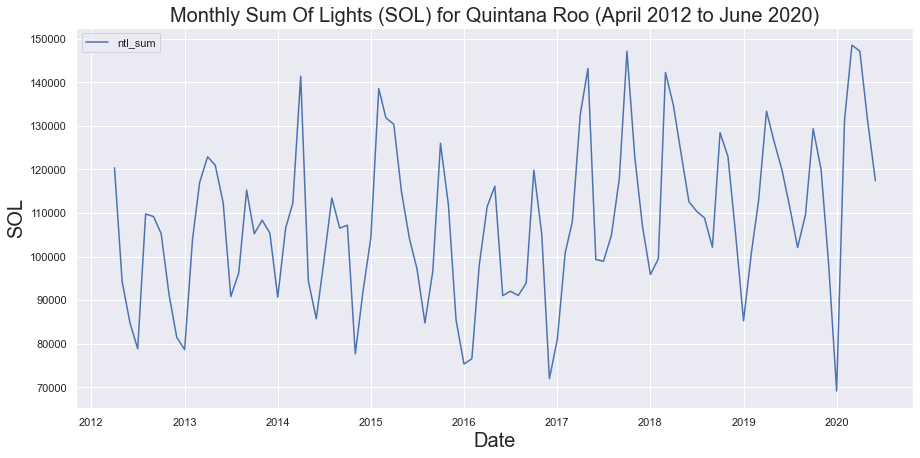

In [14]:
# Monthly sum of lights
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(data=ntl_df, ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title(f'Monthly Sum Of Lights (SOL) for {state} (April 2012 to June 2020)',fontsize=20)
date_xlim = ax.get_xlim()
sol_ylim = ax.get_ylim()
print(date_xlim)
print(sol_ylim)

[(65166.65636403498, 152484.5521984287), (734444.85, 737726.15)]

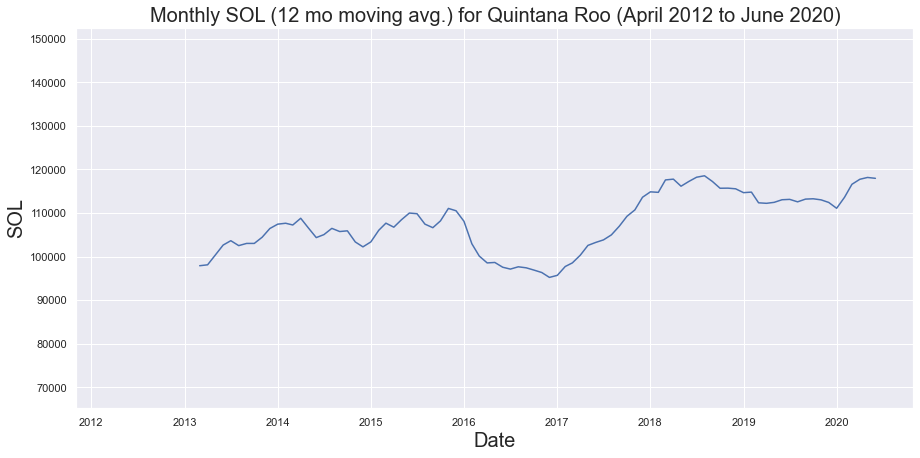

In [15]:
# Monthly sum of lights -- smoothed with 12 month rolling window
fig, ax = plt.subplots(figsize=(15,7))
window=12
sns.lineplot(data=ntl_df['ntl_sum'].rolling(window).mean(), ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title(f'Monthly SOL ({window} mo moving avg.) for {state} (April 2012 to June 2020)',fontsize=20)
ax.set(ylim=sol_ylim, xlim=date_xlim)

[(65166.65636403498, 152484.5521984287), (734444.85, 737726.15)]

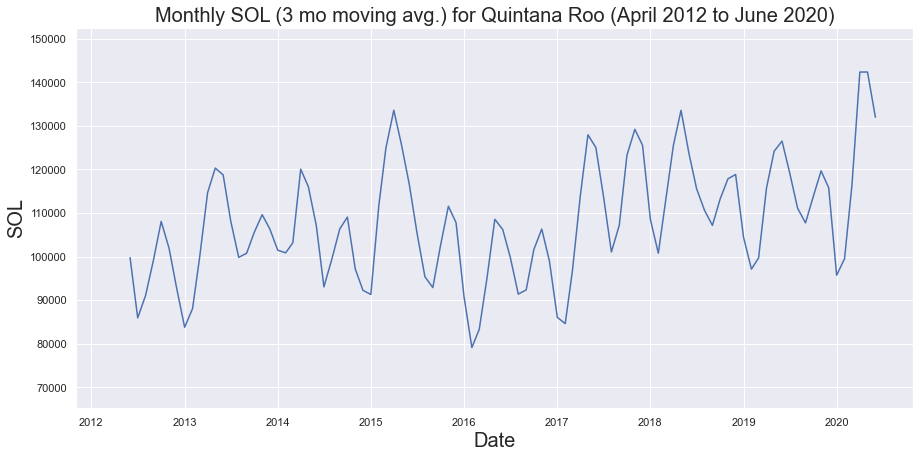

In [16]:
# Montly sum of lights -- smoothed with 3 month rolling window
fig, ax = plt.subplots(figsize=(15,7))
window=3
sns.lineplot(data=ntl_df['ntl_sum'].rolling(window).mean(), ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title(f'Monthly SOL ({window} mo moving avg.) for {state} (April 2012 to June 2020)',fontsize=20)
ax.set(ylim=sol_ylim, xlim=date_xlim)

### Quarterly

[(65166.65636403498, 152484.5521984287), (734444.85, 737726.15)]

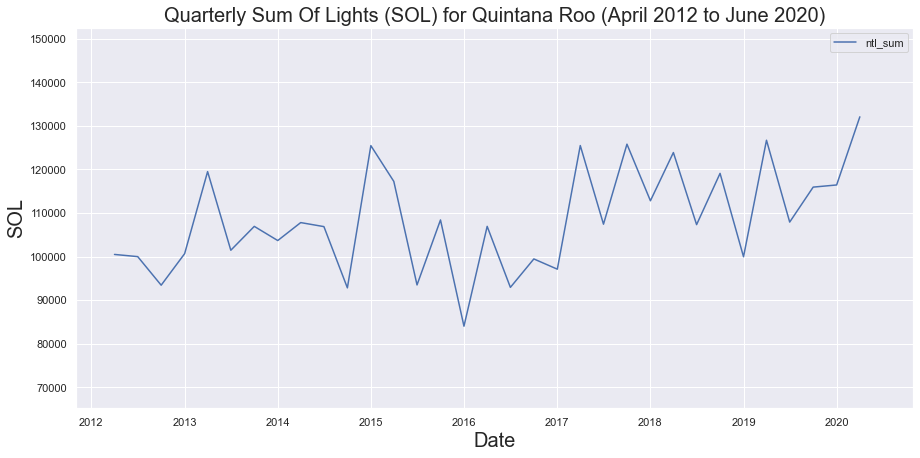

In [17]:
# Quarterly sum of lights
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(data=ntl_quarter_df, ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title(f'Quarterly Sum Of Lights (SOL) for {state} (April 2012 to June 2020)',fontsize=20)
ax.set(ylim=sol_ylim, xlim=date_xlim)

[(65166.65636403498, 152484.5521984287), (734444.85, 737726.15)]

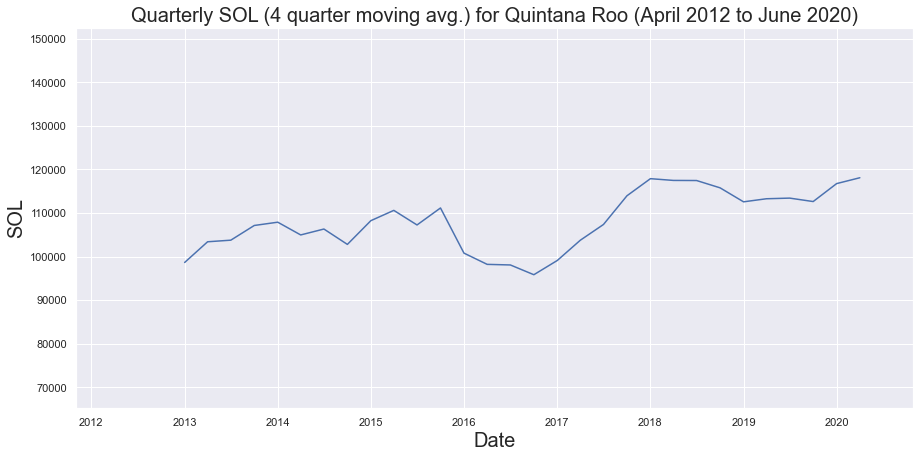

In [18]:
# Quarterly sum of lights -- smoothed with 4 quarter rolling window
fig, ax = plt.subplots(figsize=(15,7))
window=4
sns.lineplot(data=ntl_quarter_df['ntl_sum'].rolling(window).mean(), ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title(f'Quarterly SOL ({window} quarter moving avg.) for {state} (April 2012 to June 2020)',fontsize=20)
ax.set(ylim=sol_ylim, xlim=date_xlim)

## Export Monthly & Quarterly Summaries

In [19]:
out_dir = '/Users/arbailey/natcap/idb/data/work/sargassum/ntl'
ntl_df.to_csv(os.path.join(out_dir,'sumNTLQR_month.csv'),header=['mo_start','ntl_sum'], index=False)
ntl_quarter_df.to_csv(os.path.join(out_dir,'sumNTLQR_quarter.csv'),header=['qtr_start','ntl_sum'], index=False)


## View Histograms, Distributions & Thresholds

### https://worldbank.github.io/OpenNightLights/tutorials/mod3_3_conditional_operations.html

In [20]:
viirs2019_12 = NTL.filterDate("2019-12-01","2019-12-31").select('avg_rad').median()
viirs2018_12 = NTL.filterDate("2018-12-01","2018-12-31").select('avg_rad').median()
viirs2017_12 = NTL.filterDate("2017-12-01","2017-12-31").select('avg_rad').median()
viirs2016_12 = NTL.filterDate("2016-12-01","2016-12-31").select('avg_rad').median()
viirs2015_12 = NTL.filterDate("2015-12-01","2015-12-31").select('avg_rad').median()
viirs2014_12 = NTL.filterDate("2014-12-01","2014-12-31").select('avg_rad').median()
viirs2013_12 = NTL.filterDate("2013-12-01","2013-12-31").select('avg_rad').median()
viirs2012_12 = NTL.filterDate("2012-12-01","2012-12-31").select('avg_rad').median()

In [21]:
# extract a number array from this region
arr = geemap.ee_to_numpy(viirs2019_12, region=QRAdmin.first().geometry())


In [36]:
print(viirs2019_12.getInfo())

{'type': 'Image', 'bands': [{'id': 'avg_rad', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


In [34]:
arr.shape

(5, 4, 1)

In [33]:
print(arr)

[[[0.07134155]
  [0.19203126]
  [0.13941544]
  [0.04873901]]

 [[0.10440445]
  [0.19574432]
  [0.0957048 ]
  [0.055457  ]]

 [[0.10440445]
  [0.19574432]
  [0.0957048 ]
  [0.055457  ]]

 [[0.2513147 ]
  [0.18326721]
  [0.21025878]
  [0.14377335]]

 [[1.32884169]
  [0.2248259 ]
  [0.23164429]
  [0.94775099]]]


In [37]:
print(arr.flatten())

[0.07134155 0.19203126 0.13941544 0.04873901 0.10440445 0.19574432
 0.0957048  0.055457   0.10440445 0.19574432 0.0957048  0.055457
 0.2513147  0.18326721 0.21025878 0.14377335 1.32884169 0.2248259
 0.23164429 0.94775099]


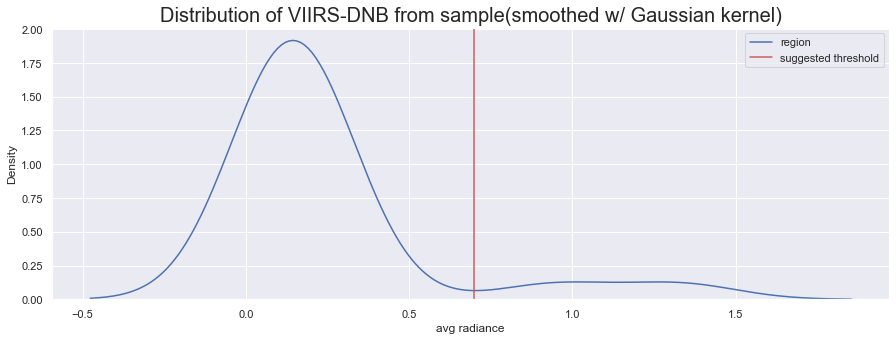

In [38]:
# create a histogram
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(arr.flatten(), label='region',legend=True, ax=ax)
ax.axvline(0.7, color='indianred', label='suggested threshold')
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS-DNB from sample(smoothed w/ Gaussian kernel)', fontsize=20)
plt.xlabel('avg radiance')
plt.legend()

In [23]:
threshold = 0.7
viirs2019_12_mask = viirs2019_12.gte(threshold)

# initialize our map
map2 = geemap.Map(center=[lat,lon],zoom=7)
map2.add_basemap('SATELLITE')

# we'll mask the image with itself to keep the visualization clean
map2.addLayer(viirs2019_12_mask.mask(viirs2019_12_mask), {}, f"Avg rad >={threshold}")
map2.addLayerControl()
map2

Map(center=[20, -87], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

In [24]:
## Map Three different thresholds for luminance levels

zones = viirs2019_12.gt(.2).add(viirs2019_12.gt(0.3)).add(viirs2019_12.gt(1))

# initialize our map
map3 = geemap.Map(center=[lat,lon],zoom=7)
map3.add_basemap('SATELLITE')

map3.addLayer(zones.mask(zones), {'palette':['#cc0909','#e67525','#fff825']}, 'zones')

map3.addLayerControl()
map3

Map(center=[20, -87], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

### https://worldbank.github.io/OpenNightLights/tutorials/mod4_2_histograms.html

In [25]:
# viirs for December 2019
viirsDec2019 = NTLclipped.filterDate('2019-12-01','2019-12-31').select('avg_rad').first()
# dec19arr = np.array(viirsDec2019.sampleRectangle(region=QRAdmin.first().geometry()).get('avg_rad').getInfo())
#. ERROR:  Too many pixels in sample; must be <= 262144. Got 583700.

In [26]:
dec19rad = geemap.extract_values_to_points(image=viirsDec2019, in_fc=QRAdmin, scale=500) 
dec19rad_df = geemap.ee_to_pandas(dec19rad)

In [27]:
dec19rad_df.describe()

,Shape_Leng,ADM1_CODE,ADM0_CODE,EXP1_YEAR,Shape_Area,STR1_YEAR,avg_rad
count,1.852140e+05,185214.0,185214.0,185214.0,1.852140e+05,185214.0,185214.000000
mean,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,0.431743
std,1.421089e-14,0.0,0.0,0.0,8.881808e-16,0.0,3.314246
min,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,-0.070000
25%,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,0.080000
50%,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,0.110000
75%,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,0.140000
max,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,139.170000


In [28]:
list(dec19rad_df)

['Shape_Leng',
 'ADM1_CODE',
 'STATUS',
 'ADM0_NAME',
 'ADM0_CODE',
 'EXP1_YEAR',
 'Shape_Area',
 'ADM1_NAME',
 'STR1_YEAR',
 'DISP_AREA',
 'avg_rad',
 'system:index']

In [29]:
# adjust values so that all negative values are set to a very small value
dec19rad_df.loc[dec19rad_df['avg_rad'] < 0, 'avg_rad'] = 0.000
# dec19rad_df['avg_rad'] = (dec19rad_df['avg_rad'] + 0.0701).where(dec19rad_df['avg_rad'] < 0, dec19rad_df['avg_rad'])
dec19rad_df.describe()
# Take the log
dec19rad_gt0_df = dec19rad_df[dec19rad_df['avg_rad'] > 0]
dec19rad_gt0_df['avg_rad_log10'] = np.log(dec19rad_gt0_df['avg_rad'])

/Users/arbailey/miniconda3/envs/geoenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [30]:
dec19rad_gt0_df.describe()

,Shape_Leng,ADM1_CODE,ADM0_CODE,EXP1_YEAR,Shape_Area,STR1_YEAR,avg_rad,avg_rad_log10
count,1.843750e+05,184375.0,184375.0,184375.0,1.843750e+05,184375.0,184375.000000,184375.000000
mean,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,0.433743,-2.170294
std,2.131634e-14,0.0,0.0,0.0,1.332271e-15,0.0,3.321645,0.862435
min,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,0.010000,-4.605170
25%,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,0.080000,-2.525729
50%,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,0.110000,-2.207275
75%,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,0.140000,-1.966113
max,3.489434e+01,2050.0,162.0,3000.0,3.736036e+00,1000.0,139.170000,4.935696


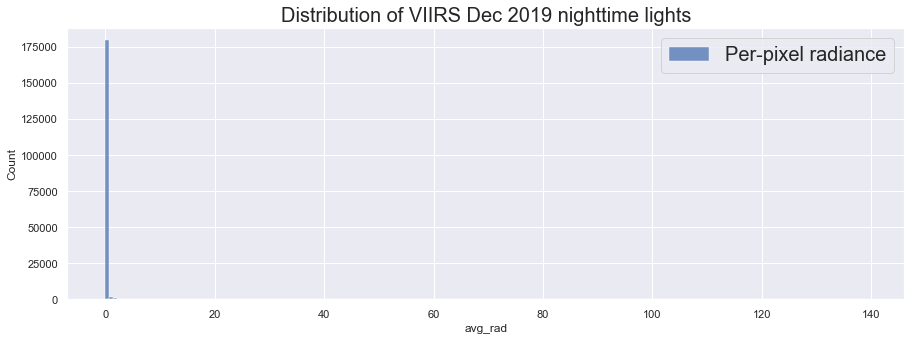

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(dec19rad_df['avg_rad'], bins=200, label='Per-pixel radiance',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS Dec 2019 nighttime lights', fontsize=20);

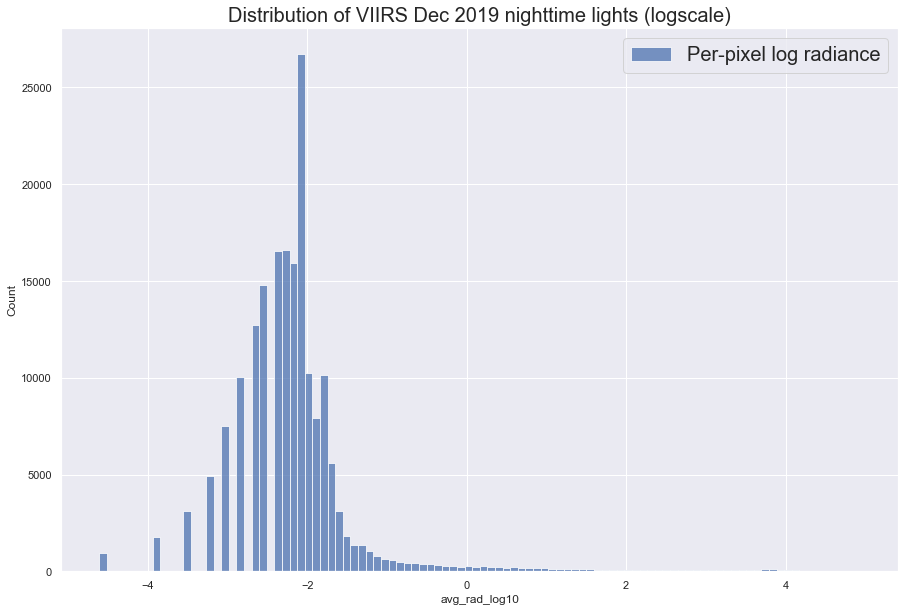

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(dec19rad_gt0_df['avg_rad_log10'], bins=100, label='Per-pixel log radiance',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS Dec 2019 nighttime lights (logscale)', fontsize=20);